# PC Yearly Automatization

## Imports and Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy as sp
import os
from itertools import combinations

import sys
import seaborn as sns
import re
import pickle


import cartopy.crs as ccrs
import cartopy.feature as cfeature



In [2]:
# Add the folder to the Python path

os.chdir("../")
# change working directory to project's root path
print(os.getcwd())

folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)

c:\Users\marti\Desktop\data\hw_extra


In [3]:

from IndexDrivers import (
    MultivariatePCA, 
    plot_hw_index,
    plot_hw_index_by_season,
    scatter_color_year,
    scatter_color_season
)

In [4]:
def df_to_series(dataframe, name_series, years=[1979,2023]):
    selected = dataframe[(dataframe["Year"]< years[1]) & (dataframe["Year"] > years[0])]
    df_melted = selected.melt(id_vars=['Year'], var_name='Month', value_name=name_series)
    df_melted["Month"] = pd.to_numeric(df_melted["Month"])
    df_melted = df_melted.sort_values(['Year','Month'])

    df_melted['Date'] = pd.to_datetime(df_melted[['Year', 'Month']].assign(DAY=1))
    df_melted.set_index('Date', inplace=True)

    return df_melted.drop(columns=["Year", "Month"])

def plot_corr(dataframe, cols):
    sns.heatmap(dataframe.corr()[cols], cmap="coolwarm", annot=True)
    plt.show()

def compute_correlations(df, num_indices=5, method='pearson'):
    """
    Compute the correlation between the first `num_indices` columns and the rest of the columns in a DataFrame
    using the specified method (Pearson, Spearman, or Kendall).
    
    Parameters:
    - df: pd.DataFrame, the input DataFrame with timeseries as columns.
    - num_indices: int, number of columns to use as the principal indices for correlation.
    - method: str, the method for correlation ('pearson', 'spearman', 'kendall').
    
    Returns:
    - pd.DataFrame with correlations between the `num_indices` columns and the rest of the columns.
    """
    if method not in ['pearson', 'spearman', 'kendall']:
        raise ValueError("Method must be 'pearson', 'spearman', or 'kendall'")

    # Extract the first `num_indices` columns as principal indices
    principal_df = df.iloc[:, :num_indices]
    
    # Extract the rest of the columns
    other_df = df.iloc[:, num_indices:]
    
    # If method is not 'pearson', we need to use rank correlation methods
    if method == 'spearman':
        # Rank the data for Spearman correlation
        principal_df = principal_df.rank()
        other_df = other_df.rank()
    elif method == 'kendall':
        # Pandas `.corr()` will be used for Kendall to handle pairwise calculation
        return other_df.corrwith(principal_df, axis=0, method='kendall')
    
    # Compute correlation matrix using dot product for Pearson or Spearman
    principal_values = principal_df.values
    other_values = other_df.values
    
    # Mean-center the data
    principal_mean_centered = principal_values - principal_values.mean(axis=0)
    other_mean_centered = other_values - other_values.mean(axis=0)
    
    # Compute the standard deviations
    principal_std = principal_values.std(axis=0)
    other_std = other_values.std(axis=0)
    
    # Normalize data
    principal_normalized = principal_mean_centered / principal_std
    other_normalized = other_mean_centered / other_std
    
    # Compute the correlation matrix using dot product
    correlations = np.dot(other_normalized.T, principal_normalized) / (other_values.shape[0] - 1)
    
    # Convert to DataFrame for readability, using original column names
    correlation_df = pd.DataFrame(
        correlations,
        columns=df.columns[:num_indices],  # Names of the principal indices columns
        index=df.columns[num_indices:]     # Names of the remaining columns
    )
    
    return correlation_df


In [5]:
ds_5means = xr.load_dataset("data/local_data/5means_world.nc")
generate_pcas = True

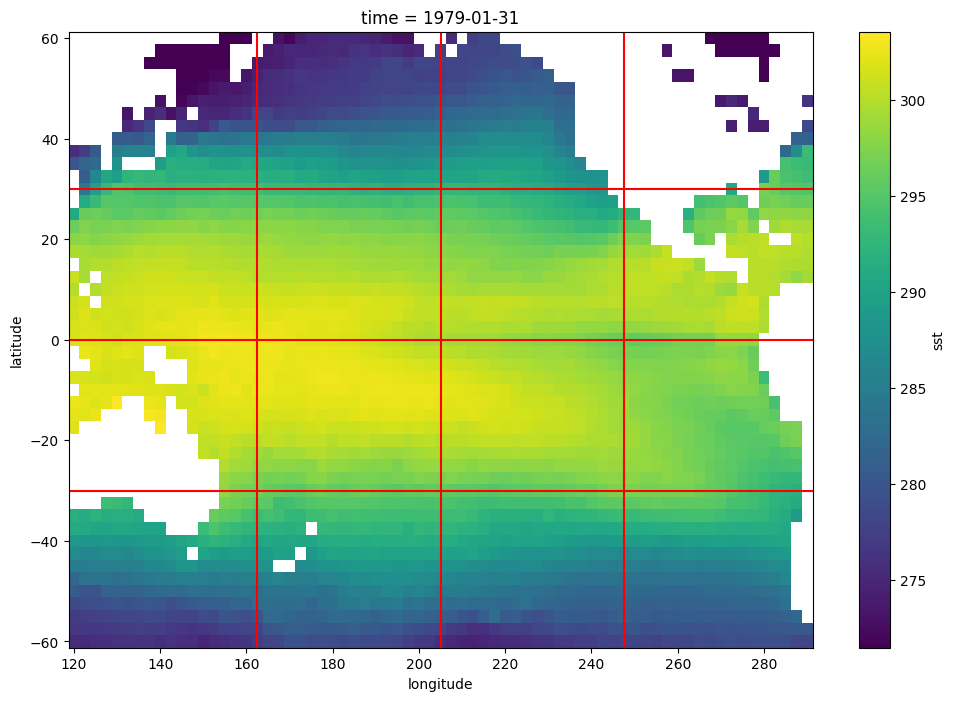

In [6]:
boxes1 = {
    0: [120,205,30,60],
    1: [205,290,30,60],
    2: [120,205,0,30],
    3: [205,290,0,30],
    4: [120,205,-30,0],
    5: [205,290,-30,0],
    6: [120,205,-60,-30],
    7: [205,290,-60,-30]
}
# New dictionary to hold 16 sub-boxes
boxes2 = {}

# Counter for keys in boxes2
new_key = 0

# Iteratively split each box into two
for key, (lon_min, lon_max, lat_min, lat_max) in boxes1.items():
    # Calculate the longitude midpoint
    lon_mid = (lon_min + lon_max) / 2
    
    # Define two new sub-boxes by splitting along the longitude midpoint
    boxes2[new_key] = [lon_min, lon_mid, lat_min, lat_max]
    new_key += 1
    boxes2[new_key] = [lon_mid, lon_max, lat_min, lat_max]
    new_key += 1

fig, axs = plt.subplots(figsize=(12,8))
ds_5means.sel(latitude=slice(-60,60), longitude=slice(120,290)).sst.isel(time=0).plot(ax=axs)
for i in range(3):
    axs.axhline(-30+i*30, c="red")
axs.axvline(205, c="red")
axs.axvline(162.5, c="red")
axs.axvline(247.5, c="red")
plt.show()

In [7]:
if generate_pcas:
    variables = ["SST", "SP", "TTR", "U10", "V10"]
    var_combi = []

    for r in range(1, len(variables) + 1):
        var_combi.extend(combinations(variables, r))

    # Iterate over each box and each combination of variables
    k = 0
    pcas = {}
    for box_id, box_coords in boxes2.items():
        for var_combination in var_combi:
            pcas[k] = MultivariatePCA(ds_5means, 3, [1980,2022], box_limit=box_coords, variables=var_combination, frequency="yearly")

            k +=1

    for box_id, box_coords in boxes1.items():
        for var_combination in var_combi:
            pcas[k] = MultivariatePCA(ds_5means, 3, [1980,2022], box_limit=box_coords, variables=var_combination, frequency="yearly")

            k +=1
else:
    with open("pcas.pkl", 'rb') as inp:
        pcas = pickle.load(inp)

In [8]:
pcas

{0: <IndexDrivers.MultivariatePCA at 0x2c57fabff70>,
 1: <IndexDrivers.MultivariatePCA at 0x2c555e673a0>,
 2: <IndexDrivers.MultivariatePCA at 0x2c57fad4eb0>,
 3: <IndexDrivers.MultivariatePCA at 0x2c555e661a0>,
 4: <IndexDrivers.MultivariatePCA at 0x2c555e64190>,
 5: <IndexDrivers.MultivariatePCA at 0x2c555e66e90>,
 6: <IndexDrivers.MultivariatePCA at 0x2c57fabe920>,
 7: <IndexDrivers.MultivariatePCA at 0x2c5265b6770>,
 8: <IndexDrivers.MultivariatePCA at 0x2c52661bd00>,
 9: <IndexDrivers.MultivariatePCA at 0x2c52661be50>,
 10: <IndexDrivers.MultivariatePCA at 0x2c528f5f0a0>,
 11: <IndexDrivers.MultivariatePCA at 0x2c528f5e530>,
 12: <IndexDrivers.MultivariatePCA at 0x2c528ff6200>,
 13: <IndexDrivers.MultivariatePCA at 0x2c528ff7a60>,
 14: <IndexDrivers.MultivariatePCA at 0x2c528fcb940>,
 15: <IndexDrivers.MultivariatePCA at 0x2c528fc9b70>,
 16: <IndexDrivers.MultivariatePCA at 0x2c528ff63b0>,
 17: <IndexDrivers.MultivariatePCA at 0x2c528ff6350>,
 18: <IndexDrivers.MultivariatePCA at 

In [9]:
hwis_chile= pd.read_csv(f"data/local_data/yearly/HWs_chile_central.csv")
hwis_chile["Date"] = pd.to_datetime(hwis_chile["Date"],format='%Y')
hwis_chile.set_index('Date', inplace=True)
hwis_cali= pd.read_csv(f"data/local_data/yearly/HWs_california.csv")
hwis_cali["Date"] = pd.to_datetime(hwis_cali["Date"],format='%Y')
hwis_cali.set_index('Date', inplace=True)


## Chile

In [11]:
first_year = 1980
hwis_chile = hwis_chile[(hwis_chile.index.year <= 2022) & (hwis_chile.index.year >= first_year)]

for mode in range(pcas[0].n_modes):
    for num, pca in pcas.items():
        hwis_chile[f"PC_{num}-Mode-{mode+1}"] = pca.get_index(mode+1, start_year=first_year)

C:\Users\marti\AppData\Local\Temp\ipykernel_12280\701160759.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hwis_chile[f"PC_{num}-Mode-{mode+1}"] = pca.get_index(mode+1, start_year=first_year)
C:\Users\marti\AppData\Local\Temp\ipykernel_12280\701160759.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hwis_chile[f"PC_{num}-Mode-{mode+1}"] = pca.get_index(mode+1, start_year=first_year)
C:\Users\marti\AppData\Local\Temp\ipykernel_12280\701160759.py:6: SettingWithCopyWarning: 
A value is trying to be set

In [12]:
corr_chile = hwis_chile.corr()[["HWN", "HWF", "HWD", "HWM", "HWA"]][5:]
corr_chile.describe()

,HWN,HWF,HWD,HWM,HWA
count,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000
mean,-0.008795,-0.012055,-0.017403,-0.006666,-0.004521
std,0.125234,0.139382,0.156690,0.103521,0.102506
min,-0.359043,-0.379292,-0.424960,-0.287204,-0.315414
25%,-0.101905,-0.118161,-0.134545,-0.078769,-0.064880
50%,-0.012636,-0.018447,-0.023159,-0.014494,-0.004082
75%,0.078694,0.094601,0.097794,0.067813,0.051236
max,0.353373,0.355507,0.393542,0.314212,0.312321


In [13]:
indices_of_interest = ["HWN", "HWF", "HWD", "HWM", "HWA"]

correlations = {
"pearson": compute_correlations(hwis_chile),
"spearman": compute_correlations(hwis_chile, method='spearman')
}
# Initialize dictionaries to hold positive and negative correlations
strong_correlations = {
    "positive": {"pearson": [], "spearman": []},
    "negative": {"pearson": [], "spearman": []}
}
any_correlations = {
    "positive": {"pearson": [], "spearman": []},
    "negative": {"pearson": [], "spearman": []}
}
# Iterate over each correlation matrix and collect pairs
for method, corr_df in correlations.items():
    for timeserie, row in corr_df.iterrows():
        for index, value in row.items():
            if value > 0.5:
                strong_correlations["positive"][method].append((timeserie, index, value))
            elif value < -0.5:
                strong_correlations["negative"][method].append((timeserie, index, value))
            if value >= 0:
                any_correlations["positive"][method].append((timeserie, index, value))
            elif value < 0:
                any_correlations["negative"][method].append((timeserie, index, value))
# Convert to DataFrames for easy viewing and saving
positive_corr_df = {
    method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
    for method, pairs in strong_correlations["positive"].items()
}
negative_corr_df = {
    method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
    for method, pairs in strong_correlations["negative"].items()
}
positive_corr_any_df = {
    method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
    for method, pairs in any_correlations["positive"].items()
}
negative_corr_any_df = {
    method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
    for method, pairs in any_correlations["negative"].items()
}
correlations_chile = [positive_corr_df, negative_corr_df]
any_corr_chile = [positive_corr_any_df, negative_corr_any_df]

In [14]:
# Initialize a list to collect all correlations from all months and methods
all_correlations = []

for method in ["pearson", "spearman"]:
    if method in any_corr_chile[0]:
        for _, row in any_corr_chile[0][method].iterrows():
            all_correlations.append((method, *row))
    
    if method in any_corr_chile[1]:
        for _, row in any_corr_chile[1][method].iterrows():
            all_correlations.append(( method, *row))

# Convert the collected data to a DataFrame for easier processing
all_correlations_df_chile = pd.DataFrame(
    all_correlations, columns=["Method", "PC", "Index", "Correlation"]
)
all_correlations_df_chile['ID'] = all_correlations_df_chile['PC'].apply(lambda x: re.search(r'PC_(.*?)-Mode-', x).group(1))
# Sort by the absolute value of the correlation and get the top 10

## Include explained variance
all_correlations_df_chile['Variance'] = all_correlations_df_chile.apply(lambda x: pcas[int(x.ID)].explained_variance[int(x.PC[-1])-1], axis=1)


top_correlations = all_correlations_df_chile.reindex(
    all_correlations_df_chile["Correlation"].abs().sort_values(ascending=False).index
).head(100)

# Display the top 10 correlations
print(top_correlations)

         Method             PC Index  Correlation   ID  Variance
18777  spearman   PC_99-Mode-2   HWD    -0.441754   99  0.259466
7507    pearson   PC_99-Mode-2   HWD    -0.435078   99  0.259466
7546    pearson  PC_112-Mode-2   HWD    -0.423061  112  0.209251
10586   pearson  PC_531-Mode-3   HWD    -0.406811  531  0.142172
5465    pearson   PC_95-Mode-1   HWD    -0.406253   95  0.511845
...         ...            ...   ...          ...  ...       ...
16790  spearman  PC_105-Mode-1   HWN    -0.353211  105  0.356908
2906    pearson  PC_545-Mode-2   HWD     0.353206  545  0.219937
2921    pearson  PC_553-Mode-2   HWD     0.352676  553  0.173020
5702    pearson  PC_200-Mode-1   HWD    -0.352482  200  0.346095
5235    pearson   PC_33-Mode-1   HWD    -0.351965   33  0.276499

[100 rows x 6 columns]


In [16]:
top1 = int(list(top_correlations["ID"])[0])
mode_top1 = int(list(top_correlations["PC"])[0][-1])
print(f"Highest correlation is PC_{top1} is on Box {pcas[top1].box} with variables {list(pcas[top1].variables_dict.values())} on mode {mode_top1}")

Highest correlation is PC_99 is on Box [247.5, 290, 30, 60] with variables ['SST', 'TTR'] on mode 2


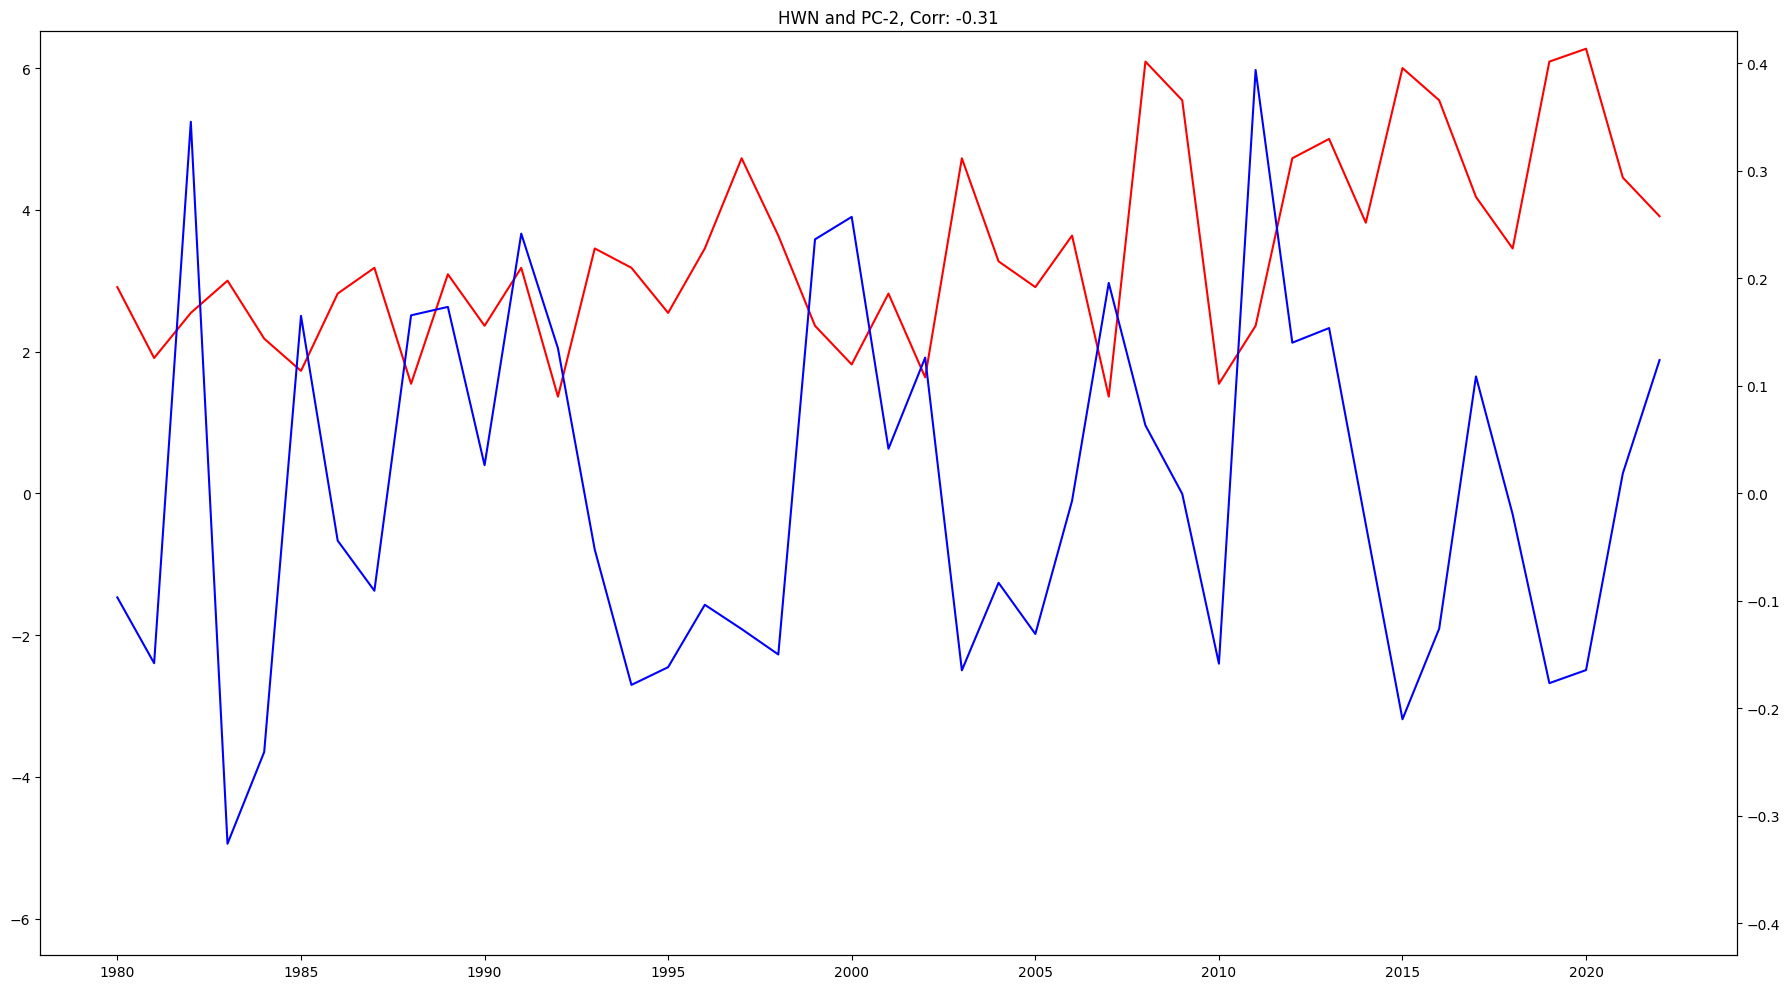

In [17]:
plot_hw_index(hwis_chile, ["HWN"], pcas[top1], mode_top1, start=first_year)

### Save top 20

In [21]:
top20_list = []
for pc in list(top_correlations["PC"]):
    if len(top20_list)==20:
        break
    elif pc not in top20_list:
        top20_list.append(pc)

top20_list

['PC_99-Mode-2',
 'PC_112-Mode-2',
 'PC_531-Mode-3',
 'PC_95-Mode-1',
 'PC_317-Mode-3',
 'PC_106-Mode-1',
 'PC_111-Mode-2',
 'PC_555-Mode-2',
 'PC_378-Mode-2',
 'PC_515-Mode-2',
 'PC_529-Mode-1',
 'PC_316-Mode-3',
 'PC_502-Mode-2',
 'PC_557-Mode-2',
 'PC_552-Mode-2',
 'PC_44-Mode-1',
 'PC_206-Mode-1',
 'PC_344-Mode-3',
 'PC_105-Mode-1',
 'PC_254-Mode-1']

In [22]:
hws_top20 = hwis_chile[indices_of_interest + top20_list]
hws_top20.to_csv("HWs_chile_features_yearly.csv")

## California

In [24]:
first_year = 1989
hwis_cali = hwis_cali[(hwis_cali.index.year <= 2022) & (hwis_cali.index.year >= first_year)]

for mode in range(pcas[0].n_modes):
    for num, pca in pcas.items():
        hwis_cali[f"PC_{num}-Mode-{mode+1}"] = pca.get_index(mode+1, start_year=first_year)

C:\Users\marti\AppData\Local\Temp\ipykernel_12280\1342745998.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hwis_cali[f"PC_{num}-Mode-{mode+1}"] = pca.get_index(mode+1, start_year=first_year)
C:\Users\marti\AppData\Local\Temp\ipykernel_12280\1342745998.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hwis_cali[f"PC_{num}-Mode-{mode+1}"] = pca.get_index(mode+1, start_year=first_year)
C:\Users\marti\AppData\Local\Temp\ipykernel_12280\1342745998.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the 

In [25]:
corr_cali = hwis_cali.corr()[["HWN", "HWF", "HWD", "HWM", "HWA"]][5:]
corr_cali.describe()

,HWN,HWF,HWD,HWM,HWA
count,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000
mean,0.018449,0.023089,0.028330,0.009909,0.016801
std,0.202339,0.200919,0.185314,0.125898,0.156474
min,-0.542537,-0.564396,-0.466097,-0.367012,-0.453763
25%,-0.127264,-0.119933,-0.121022,-0.078535,-0.100025
50%,0.013281,0.019149,0.032845,0.018807,0.014378
75%,0.174150,0.181098,0.179476,0.098177,0.133376
max,0.537761,0.523114,0.452089,0.371759,0.460456


In [27]:
indices_of_interest = ["HWN", "HWF", "HWD", "HWM", "HWA"]

correlations = {
"pearson": compute_correlations(hwis_cali),
"spearman": compute_correlations(hwis_cali, method='spearman')
}
# Initialize dictionaries to hold positive and negative correlations
strong_correlations = {
    "positive": {"pearson": [], "spearman": []},
    "negative": {"pearson": [], "spearman": []}
}
any_correlations = {
    "positive": {"pearson": [], "spearman": []},
    "negative": {"pearson": [], "spearman": []}
}
# Iterate over each correlation matrix and collect pairs
for method, corr_df in correlations.items():
    for timeserie, row in corr_df.iterrows():
        for index, value in row.items():
            if value > 0.5:
                strong_correlations["positive"][method].append((timeserie, index, value))
            elif value < -0.5:
                strong_correlations["negative"][method].append((timeserie, index, value))
            if value >= 0:
                any_correlations["positive"][method].append((timeserie, index, value))
            elif value < 0:
                any_correlations["negative"][method].append((timeserie, index, value))
# Convert to DataFrames for easy viewing and saving
positive_corr_df = {
    method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
    for method, pairs in strong_correlations["positive"].items()
}
negative_corr_df = {
    method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
    for method, pairs in strong_correlations["negative"].items()
}
positive_corr_any_df = {
    method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
    for method, pairs in any_correlations["positive"].items()
}
negative_corr_any_df = {
    method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
    for method, pairs in any_correlations["negative"].items()
}
correlations_chile = [positive_corr_df, negative_corr_df]
any_corr_chile = [positive_corr_any_df, negative_corr_any_df]

In [29]:
# Initialize a list to collect all correlations from all months and methods
all_correlations = []

for method in ["pearson", "spearman"]:
    if method in any_corr_chile[0]:
        for _, row in any_corr_chile[0][method].iterrows():
            all_correlations.append((method, *row))
    
    if method in any_corr_chile[1]:
        for _, row in any_corr_chile[1][method].iterrows():
            all_correlations.append(( method, *row))

# Convert the collected data to a DataFrame for easier processing
all_correlations_df_cali = pd.DataFrame(
    all_correlations, columns=["Method", "PC", "Index", "Correlation"]
)
all_correlations_df_cali['ID'] = all_correlations_df_cali['PC'].apply(lambda x: re.search(r'PC_(.*?)-Mode-', x).group(1))
# Sort by the absolute value of the correlation and get the top 10

## Include explained variance
all_correlations_df_cali['Variance'] = all_correlations_df_cali.apply(lambda x: pcas[int(x.ID)].explained_variance[int(x.PC[-1])-1], axis=1)


top_correlations = all_correlations_df_cali.reindex(
    all_correlations_df_cali["Correlation"].abs().sort_values(ascending=False).index
).head(100)

# Display the top 10 correlations
print(top_correlations)

         Method             PC Index  Correlation   ID  Variance
19917  spearman  PC_483-Mode-2   HWF    -0.641056  483  0.165569
19907  spearman  PC_480-Mode-2   HWF    -0.634287  480  0.184376
20993  spearman  PC_191-Mode-3   HWN    -0.623161  191  0.092554
11196  spearman    PC_8-Mode-1   HWF     0.620591    8  0.440733
11239  spearman   PC_19-Mode-1   HWF     0.619331   19  0.310423
...         ...            ...   ...          ...  ...       ...
15120  spearman  PC_718-Mode-2   HWF     0.544552  718  0.218913
19908  spearman  PC_480-Mode-2   HWD    -0.544023  480  0.184376
15160  spearman  PC_732-Mode-2   HWF     0.543450  732  0.144418
18159  spearman  PC_498-Mode-1   HWF    -0.543292  498  0.209569
20431  spearman  PC_720-Mode-2   HWD    -0.543235  720  0.210412

[100 rows x 6 columns]


In [30]:
top1 = int(list(top_correlations["ID"])[0])
mode_top1 = int(list(top_correlations["PC"])[0][-1])
print(f"Highest correlation is PC_{top1} is on Box {pcas[top1].box} with variables {list(pcas[top1].variables_dict.values())} on mode {mode_top1}")

Highest correlation is PC_483 is on Box [247.5, 290, -60, -30] with variables ['SST', 'TTR', 'U10'] on mode 2


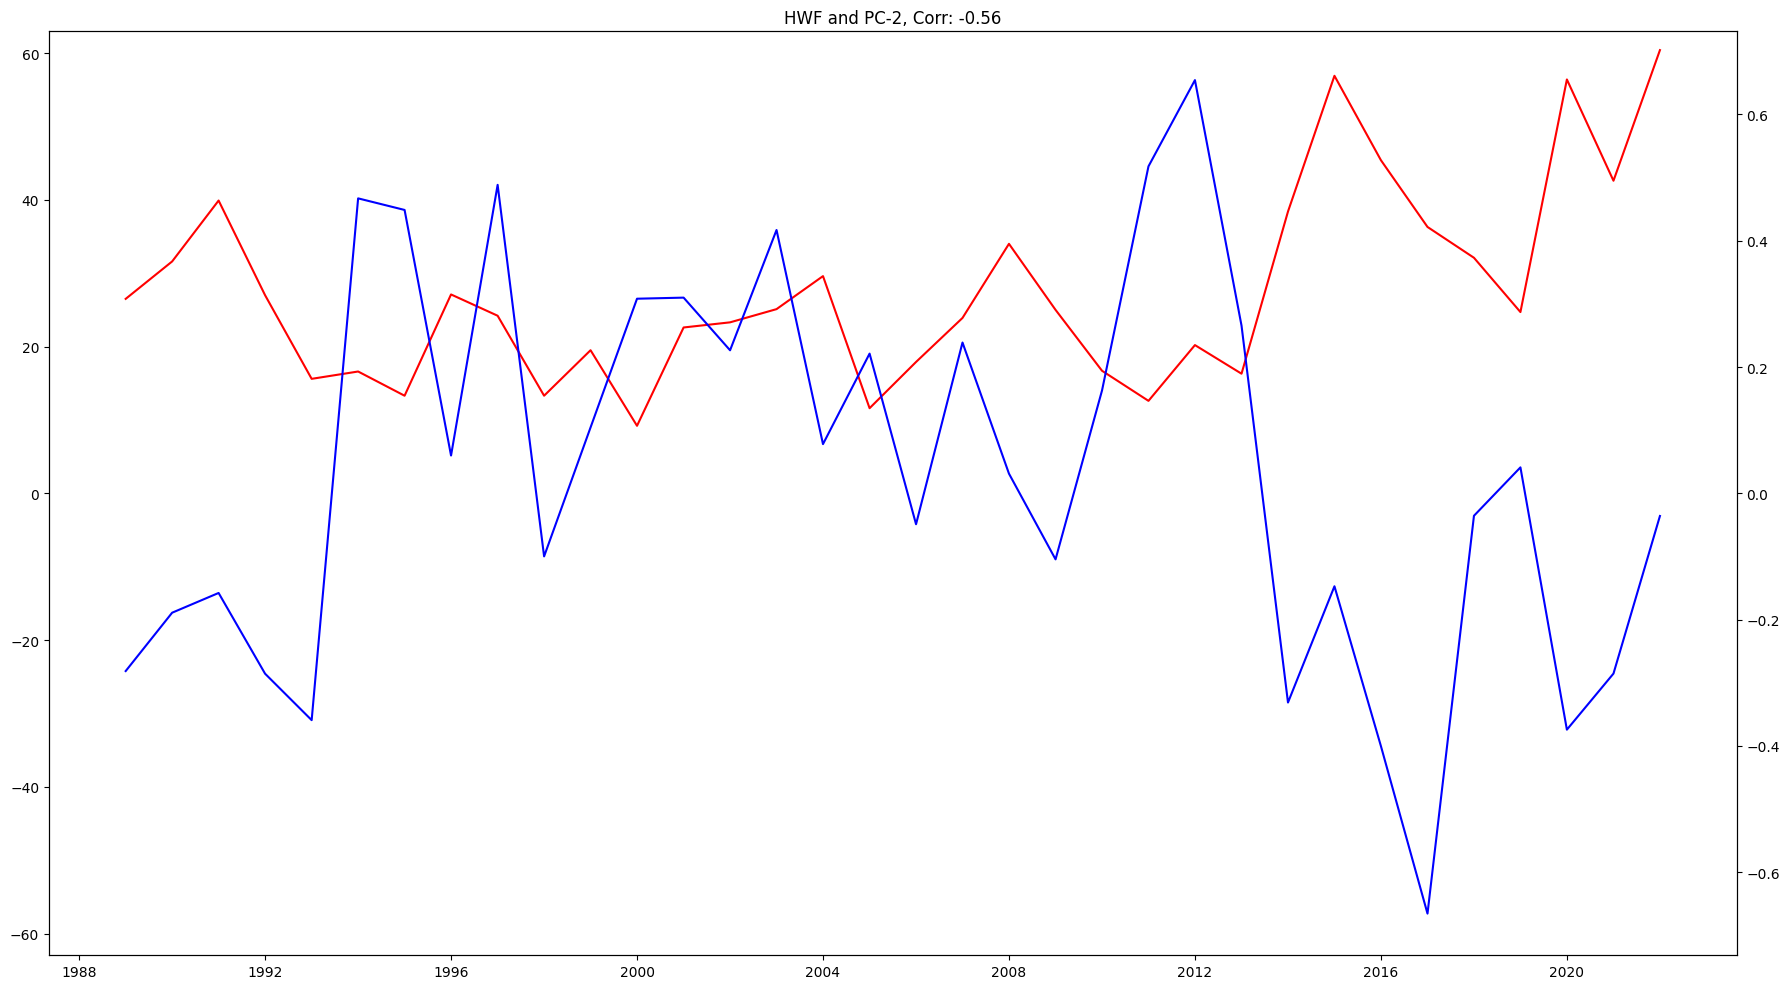

In [31]:
plot_hw_index(hwis_cali, ["HWF"], pcas[top1], mode_top1, start=first_year)

### Save top 20

In [32]:
top20_list = []
for pc in list(top_correlations["PC"]):
    if len(top20_list)==20:
        break
    elif pc not in top20_list:
        top20_list.append(pc)

top20_list

['PC_483-Mode-2',
 'PC_480-Mode-2',
 'PC_191-Mode-3',
 'PC_8-Mode-1',
 'PC_19-Mode-1',
 'PC_6-Mode-1',
 'PC_0-Mode-1',
 'PC_733-Mode-2',
 'PC_231-Mode-3',
 'PC_465-Mode-1',
 'PC_728-Mode-2',
 'PC_248-Mode-3',
 'PC_515-Mode-1',
 'PC_18-Mode-1',
 'PC_28-Mode-1',
 'PC_713-Mode-1',
 'PC_484-Mode-2',
 'PC_471-Mode-1',
 'PC_98-Mode-1',
 'PC_731-Mode-2']

In [33]:
hws_top20 = hwis_cali[indices_of_interest + top20_list]
hws_top20.to_csv("HWs_cali_features_yearly.csv")